# Data Peperation: 
Step by step overview: 
1. Summarize our data:
- head(), describe(), info(), isnull(), value_counts(), shape, ...
- plt.hist(), plt.boxplot()
- document takeaways (nulls, datatypes to change, outliers, ideas for features, etc.)

2. Clean the data:
- rename columns
    - missing values: drop columns with too many missing values, drop rows with too many missing values, fill with zero where it makes sense, and then make note of any columns you want to impute missing values in (you will need to do that on split data).
    - outlier: an observation point that is distant from other observations
    https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/
    - ignore, drop rows, snap to a selected max/min value, create bins (cut, qcut)
    - data errors: drop the rows/observations with the errors, correct them to what it was intended
    - address text normalization issues: correct and standardize tex (e.g. deck 'C' 'c')
    - creating new variables out of existing variables (e.g. z = x - y)

3. Split the data:
- split our data into train, validate and test sample dataframes
    - train: in-sample, explore, impute mean, scale numeric data (max() - min()...), fit our ml algorithms, evaluate our models.
    - validate: out-of-sample confirm our top models have not overfit, evaluate our top models on unseen data. Using validate performance results, we pick the top 1 model.
    - test: out-of-sample, how we expect our top model to perform in production, on unseen data in the future. ONLY USED ON 1 MODEL.

## Begin Cleaning

In [1]:
# imports:
import pandas as pd
import numpy as np

#personal
import wrangle as wr

In [2]:
# aquire the data:
df = wr.get_zillow_data()
df.head()

,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt,propertylandusetypeid,propertylandusedesc,yearbuilt
0,2017-01-13,2.0,3.0,1324.0,6037.0,518089.0,261.0,Single Family Residential,1963.0
1,2017-01-13,3.0,4.0,3551.0,6037.0,1609238.0,261.0,Single Family Residential,1994.0
2,2017-01-13,3.0,4.0,2519.0,6037.0,106406.0,261.0,Single Family Residential,1965.0
3,2017-01-13,2.0,3.0,1285.0,6037.0,369853.0,261.0,Single Family Residential,1955.0
4,2017-01-13,1.0,3.0,1254.0,6037.0,65848.0,261.0,Single Family Residential,1954.0


In [3]:
# describe the data:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt,propertylandusetypeid,yearbuilt
count,52441.000000,52441.000000,52359.000000,52441.000000,5.244000e+04,52441.0,52325.000000
mean,2.299403,3.300681,1922.890754,6049.132149,5.296882e+05,261.0,1963.393884
std,1.022772,0.949094,1004.365838,21.029067,7.518946e+05,0.0,23.133571
min,0.000000,0.000000,128.000000,6037.000000,1.000000e+03,261.0,1878.000000
25%,2.000000,3.000000,1268.000000,6037.000000,1.937475e+05,261.0,1950.000000
50%,2.000000,3.000000,1659.000000,6037.000000,3.736120e+05,261.0,1961.000000
75%,3.000000,4.000000,2306.000000,6059.000000,6.193012e+05,261.0,1979.000000
max,18.000000,14.000000,21929.000000,6111.000000,4.906124e+07,261.0,2016.000000


In [4]:
# look at the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transactiondate               52441 non-null  object 
 1   bathroomcnt                   52441 non-null  float64
 2   bedroomcnt                    52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   fips                          52441 non-null  float64
 5   taxvaluedollarcnt             52440 non-null  float64
 6   propertylandusetypeid         52441 non-null  float64
 7   propertylandusedesc           52441 non-null  object 
 8   yearbuilt                     52325 non-null  float64
dtypes: float64(7), object(2)
memory usage: 4.0+ MB


>We will want to drop transactiondate, it was just a place holder to make sure all our transactions were in 2017. We can also drop popertylandusetypeid and propetylandusedesc as these were also confirmation place holders for single family properties.

- Domian knoweldge = fips are the counties, need to look up with number corelates with each county. Use this column to make a table to answer the question regarding missing location, state, and county information requested by zillow. 


In [5]:
# look at how many nulls there are: 
df.isna().sum()

transactiondate                   0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     82
fips                              0
taxvaluedollarcnt                 1
propertylandusetypeid             0
propertylandusedesc               0
yearbuilt                       116
dtype: int64

In [6]:
# what percentage of the data base is missing?
df.isna().sum()/ df.shape[0] * 100

transactiondate                 0.000000
bathroomcnt                     0.000000
bedroomcnt                      0.000000
calculatedfinishedsquarefeet    0.156366
fips                            0.000000
taxvaluedollarcnt               0.001907
propertylandusetypeid           0.000000
propertylandusedesc             0.000000
yearbuilt                       0.221201
dtype: float64

>The nulls that are missing only make up 0.1 % and 0.02 % percent of the data base, so it would be safe to drop these values since we are only losing about half a percent of the data

## Zillow request for location before removing column

In [7]:
# figure out the fips first and make a table for zillow
location = pd.DataFrame(df['fips'])
location.value_counts()

fips  
6037.0    33910
6059.0    14136
6111.0     4395
dtype: int64

There are thee codes: 6037,6059,6111.
- 6037 = Los Angeles County, California
- 6059 = Orange County, California
- 6111 = Ventura County, California

In [8]:
# i want to reasign these values and then make a graph: 
county_maps = {6037: 'Los Angeles',
6059: 'Orange',
6111: 'Ventura'
}

In [9]:
location['county'] = location.fips.map(county_maps)
location.value_counts()

fips    county     
6037.0  Los Angeles    33910
6059.0  Orange         14136
6111.0  Ventura         4395
dtype: int64

In [10]:
# import visualization tools:
import matplotlib.pyplot as plt
import seaborn as sns

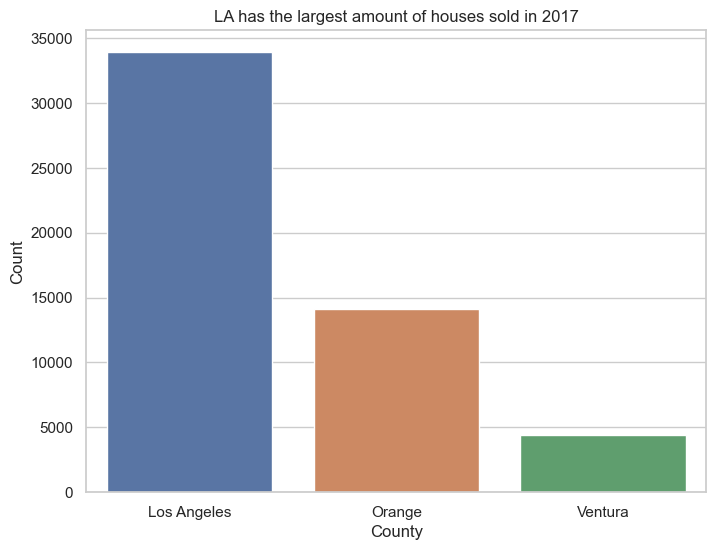

In [11]:

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

sns.countplot(x = 'county', data = location)
plt.xlabel('County')
plt.ylabel('Count')
plt.title('LA has the largest amount of houses sold in 2017')
plt.show()

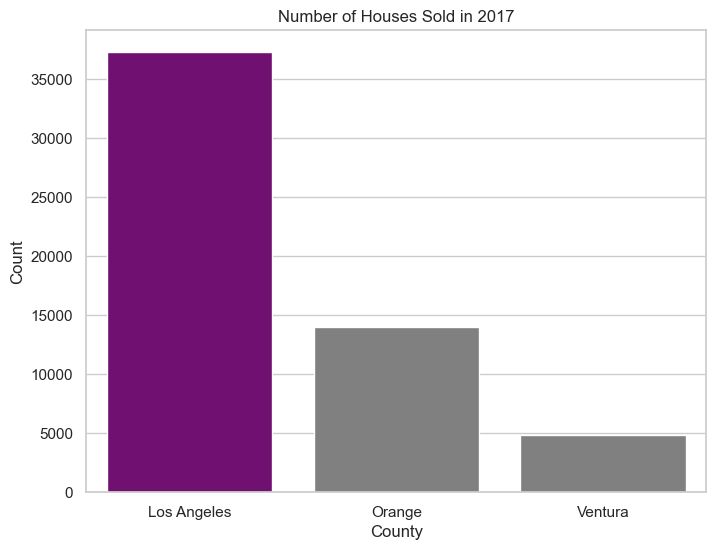

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the provided data
data = pd.DataFrame({
    'fips': [6037.0, 6059.0, 6111.0],
    'county': ['Los Angeles', 'Orange', 'Ventura'],
    'count': [37288, 13972, 4820]
})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a custom color palette
colors = ['grey' if county != 'Los Angeles' else 'purple' for county in data['county']]

sns.barplot(x='county', y='count', data=data, palette=colors)
plt.xlabel('County')
plt.ylabel('Count')
plt.title('Number of Houses Sold in 2017')
plt.show()


## Return to cleaning the dataset

In [13]:
# drop the columns that we don't need: 
drop_cols = ['transactiondate','propertylandusetypeid','propertylandusedesc','fips']

df = df.drop(columns = drop_cols)

In [14]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt
0,2.0,3.0,1324.0,518089.0,1963.0
1,3.0,4.0,3551.0,1609238.0,1994.0
2,3.0,4.0,2519.0,106406.0,1965.0
3,2.0,3.0,1285.0,369853.0,1955.0
4,1.0,3.0,1254.0,65848.0,1954.0


In [15]:
df = df.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52319 non-null  float64
 1   bedroomcnt                    52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   yearbuilt                     52319 non-null  float64
dtypes: float64(5)
memory usage: 2.4 MB


In [17]:
# rename the columns to easier to understand names:
df = df.rename(columns ={
    'bathroomcnt': 'bathrooms',
    'bedroomcnt': 'bedrooms',
    'calculatedfinishedsquarefeet': 'sqft',
    'taxvaluedollarcnt': 'tax_value'
})
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt
0,2.0,3.0,1324.0,518089.0,1963.0
1,3.0,4.0,3551.0,1609238.0,1994.0
2,3.0,4.0,2519.0,106406.0,1965.0
3,2.0,3.0,1285.0,369853.0,1955.0
4,1.0,3.0,1254.0,65848.0,1954.0


In [18]:
# make a function to clean and prep the data
def clean_zillow(df):
    '''
    This function:
    - This function will drop nulls
    - This function, will drop unescessary columns
    - Rename the existing columns
    '''
    
    # drop nulls
    df = df.dropna()
    
    col_list = ['transactiondate','propertylandusetypeid','propertylandusedesc','fips']
    
    #drop column names in col_list
    df = df.drop(columns = col_list)
    
    #rename the columns
    df = df.rename(columns ={
    'bathroomcnt': 'bathrooms',
    'bedroomcnt': 'bedrooms',
    'calculatedfinishedsquarefeet': 'sqft',
    'taxvaluedollarcnt': 'tax_value'
})  
    return df

In [19]:
df = wr.get_zillow_data()
df.head()

,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt,propertylandusetypeid,propertylandusedesc,yearbuilt
0,2017-01-13,2.0,3.0,1324.0,6037.0,518089.0,261.0,Single Family Residential,1963.0
1,2017-01-13,3.0,4.0,3551.0,6037.0,1609238.0,261.0,Single Family Residential,1994.0
2,2017-01-13,3.0,4.0,2519.0,6037.0,106406.0,261.0,Single Family Residential,1965.0
3,2017-01-13,2.0,3.0,1285.0,6037.0,369853.0,261.0,Single Family Residential,1955.0
4,2017-01-13,1.0,3.0,1254.0,6037.0,65848.0,261.0,Single Family Residential,1954.0


In [20]:
df = clean_zillow(df)

In [21]:
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt
0,2.0,3.0,1324.0,518089.0,1963.0
1,3.0,4.0,3551.0,1609238.0,1994.0
2,3.0,4.0,2519.0,106406.0,1965.0
3,2.0,3.0,1285.0,369853.0,1955.0
4,1.0,3.0,1254.0,65848.0,1954.0


# Feature Engineering
- I want to make some new columns that could be used such as number of rooms: a combination of bathrooms and of bedrooms
- I want to make a new column for how old the houses are
- I want to remove outliers that could be messing with the data

In [22]:
# make a column for how old the house is
df['house_age'] = 2017 - df['yearbuilt']

In [23]:
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age
0,2.0,3.0,1324.0,518089.0,1963.0,54.0
1,3.0,4.0,3551.0,1609238.0,1994.0,23.0
2,3.0,4.0,2519.0,106406.0,1965.0,52.0
3,2.0,3.0,1285.0,369853.0,1955.0,62.0
4,1.0,3.0,1254.0,65848.0,1954.0,63.0


In [24]:
# make a column for total rooms (bathrooms + bedrooms)
df['bb_roomcnt'] = df['bathrooms'] + df['bedrooms']

In [25]:
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
0,2.0,3.0,1324.0,518089.0,1963.0,54.0,5.0
1,3.0,4.0,3551.0,1609238.0,1994.0,23.0,7.0
2,3.0,4.0,2519.0,106406.0,1965.0,52.0,7.0
3,2.0,3.0,1285.0,369853.0,1955.0,62.0,5.0
4,1.0,3.0,1254.0,65848.0,1954.0,63.0,4.0


In [26]:
# make a function: 
def create_columns(df):
    '''
    This function will complete some feature engineering and produce two columns:
    house age = how old the house is
    bb_roomcnt = bedrooms with bathrroms 
    '''
    
    df['house_age'] = 2017 - df['yearbuilt']
    
    df['bb_roomcnt'] = df['bathrooms'] + df['bedrooms']
    
    
    return df

# Split Data:
- Need to create a function to split the data into train, validate, and test

In [27]:
# impots
from sklearn.model_selection import train_test_split

In [28]:
def split_zillow_data(df):
    '''
    This funciton will split the data frame into train, validate, and test
    '''
    
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    return train, validate, test

In [29]:
# make sure it works
train, validate, test = split_zillow_data(df)

In [30]:
train.shape, validate.shape, test.shape

((29298, 7), (12557, 7), (10464, 7))

In [31]:
# check combined functions: 
train, validate, test = wr.prep_zillow()
train.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
20546,1.0,3.0,1016.0,296465.0,1956.0,61.0,4.0
6657,1.0,2.0,1140.0,111502.0,1947.0,70.0,3.0
51315,1.0,2.0,1226.0,235041.0,1940.0,77.0,3.0
43279,1.0,1.0,722.0,142547.0,1923.0,94.0,2.0
19693,2.0,4.0,1977.0,83510.0,1967.0,50.0,6.0
